# Análisis Exploratorio inicial

Exploración de las primeras tres preguntas del proyecto de pronóstico de demanda usando únicamente `pandas` y `matplotlib`.


In [145]:

import pandas as pd 
import matplotlib.pyplot as plt

CSV = "ventas_hiperrealistas.csv"
ProductosAnalisis = ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
meses = ["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"]

#recorre la lista meses asociando un indice (Ene = 1), en donde label es el mes e idx el numero asociado
NumeroMes = {idx + 1: label for idx, label in enumerate(meses)} 
#trabajaremos con series temporales históricas para extraer tendencias y estacionalidad antes de modelar.


In [146]:

df = pd.read_csv(CSV, parse_dates=["Date"])


columnas = df.columns.tolist() #lista con los encabezados
rango = (df["Date"].min().date(), df["Date"].max().date())
print(f"Primer y último registro: {rango[0]} a {rango[1]}")
#Primeras 5 filas
print("primeras 5 filas")
df.head()


Primer y último registro: 2012-01-01 a 2020-12-31
primeras 5 filas


,TransactionID,Date,ProductID,ProductName,ProductCategory,Quantity,UnitPrice,TotalPrice
0,1,2012-01-01,402,Leche Entera 1L,Lácteos,2,950,1900
1,2,2012-01-01,103,Pan de Molde Blanco,Panadería,1,1800,1800
2,3,2012-01-01,101,Refresco Cola 2L,Bebidas,2,1500,3000
3,4,2012-01-01,402,Leche Entera 1L,Lácteos,1,950,950
4,5,2012-01-01,401,Yogurt Frutilla 125g,Lácteos,3,400,1200


## Preguntas


## 1. Análisis Exploratorio y Visualización (15 Puntos)


1.1. Visión Agregada (5 Puntos): Genere un gráfico de series de tiempo que muestre la evolución de la Cantidad total vendida (sumando todos los productos) a lo largo del tiempo. Comente la tendencia general y cualquier patrón cíclico o estacional que observe a nivel macro.

En esta sección, quisimos aplicar además el método de medias moíviles para poder visualizar de una froma alisada el comportamiento de los datos y así detectar de mejor medida patrones cíclicos y/o estacionales

In [147]:

# Series de tiempo: agregamos transacciones a nivel diario (unidades y ventas).

#ordenasmos las ventas diarias, agrupando por fecha y suma de las cantidades vendidas en esa fecha
ventas_diarias = (
    df.groupby('Date')
      .agg(TotalUnidadesDia=('Quantity', 'sum'),
           TotalVentasDia=('TotalPrice', 'sum'))
      .reset_index()
      .sort_values('Date')
)

# Medias móviles de 30 días en unidades y ventas
#PU30: Promedio unidades a 30 dias
#PV30: Promedio Ventas a 30 dias
ventas_diarias['PU30'] = ventas_diarias['TotalUnidadesDia'].rolling(window=30, min_periods=30).mean().shift(1)
ventas_diarias['PV30'] = ventas_diarias['TotalVentasDia'].rolling(window=30, min_periods=30).mean().shift(1)

#Resumen a grandes rasgos del CSV

resumen_unidades = {
    'Inicio operaciones': ventas_diarias['Date'].min().date(),
    'Final de operaciones': ventas_diarias['Date'].max().date(),
    'Promedio diario (unidades)': round(ventas_diarias['TotalUnidadesDia'].mean(), 0),
    'Máximo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].max()),
    'Mínimo diario (unidades)': int(ventas_diarias['TotalUnidadesDia'].min()),
}
resumen_ventas = {
    'Promedio diario ($)': round(ventas_diarias['TotalVentasDia'].mean(), 0),
    'Máximo diario ($)': round(ventas_diarias['TotalVentasDia'].max(), 0),
    'Mínimo diario ($)': round(ventas_diarias['TotalVentasDia'].min(), 0),
}

print('Resumen de la serie diaria (unidades):')
for i, valor in resumen_unidades.items():
    print(f'  {i}: {valor}')
print()
print('Resumen de la serie diaria (ventas $):')
for i, valor in resumen_ventas.items():
    print(f'  {i}: {valor}')


Resumen de la serie diaria (unidades):
  Inicio operaciones: 2012-01-01
  Final de operaciones: 2020-12-31
  Promedio diario (unidades): 479.0
  Máximo diario (unidades): 2085
  Mínimo diario (unidades): 134

Resumen de la serie diaria (ventas $):
  Promedio diario ($): 1046712.0
  Máximo diario ($): 4521600
  Mínimo diario ($): 276600


Graficos por dia, método Medias Móviles a 30 dias

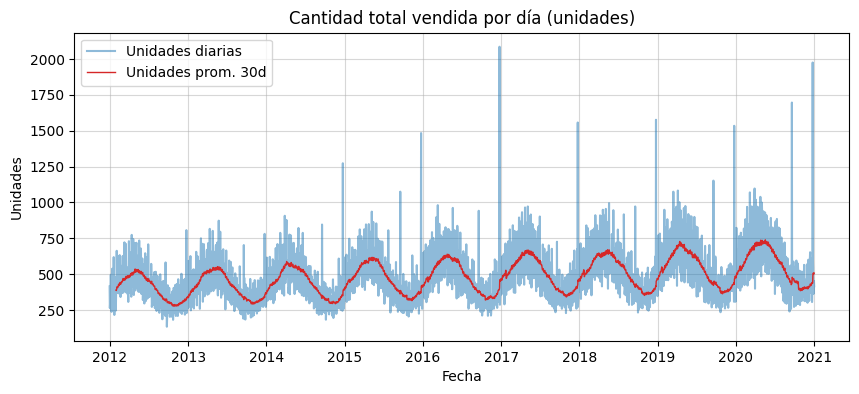

In [148]:
#Grafica Serie de tiempo con método medias moviles a 30 dias
#Unidades vendidas
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalUnidadesDia'], label='Unidades diarias', alpha=0.5, color='tab:blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PU30'], label='Unidades prom. 30d', linewidth=1, color='tab:red')
ax.set_title('Cantidad total vendida por día (unidades)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades')
ax.legend()
ax.grid(alpha=0.5)
plt.show()


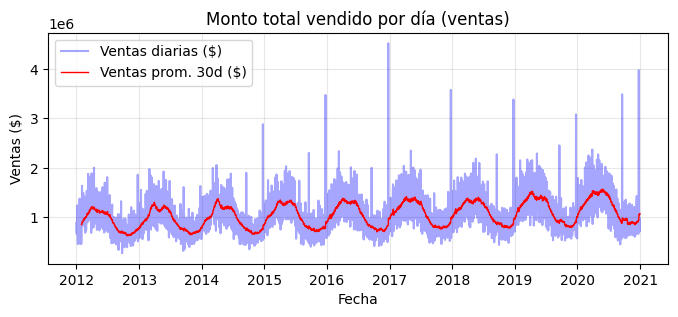

In [149]:
#Grafica Serie de tiempo con método medias moviles a 30 dias
#Ventas en $

ventas_diarias['TotalVentasDia']=ventas_diarias['TotalVentasDia']
ventas_diarias['PV30']=ventas_diarias['PV30']

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(ventas_diarias['Date'], ventas_diarias['TotalVentasDia'], label='Ventas diarias ($)', alpha=0.35, color='blue')
ax.plot(ventas_diarias['Date'], ventas_diarias['PV30'], label='Ventas prom. 30d ($)', linewidth=1, color='red')
ax.set_title('Monto total vendido por día (ventas)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Ventas ($)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


In [150]:
# Resumen anual para unidades y ventas.

ventas_anuales = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('YE')
    .sum()
)


promedio_anual_unidades = ventas_anuales['TotalUnidadesDia'].mean()
promedio_anual_ventas = ventas_anuales['TotalVentasDia'].mean()
print('Unidades y ventas por año:')
print(f"Promedio anual de unidades vendidas: {promedio_anual_unidades}")
print(f"Promedio anual de ventas ($): {promedio_anual_ventas}")
ventas_anuales

Unidades y ventas por año:
Promedio anual de unidades vendidas: 175133.88888888888
Promedio anual de ventas ($): 382398927.7777778


,TotalUnidadesDia,TotalVentasDia
Date,,
2012-12-31,145979,331267350
2013-12-31,152325,343182900
2014-12-31,158868,353741800
2015-12-31,169437,373091200
2016-12-31,175714,383108500
2017-12-31,183417,394604450
2018-12-31,187990,401120650
2019-12-31,196350,419649450
2020-12-31,206125,441824050


In [151]:

# Promedios mensuales (promedio de todos los enero, febrero, etc.)
resumen_promedios_mensuales = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('MS')
    .sum()
    .groupby(lambda fecha: fecha.month)
    .mean()
)
resumen_promedios_mensuales.index = [NumeroMes[idx] for idx in resumen_promedios_mensuales.index]

print('Promedio mensual histórico de unidades y ventas:')
resumen_promedios_mensuales.round(1)


Promedio mensual histórico de unidades y ventas:


,TotalUnidadesDia,TotalVentasDia
Ene,14644.8,32713727.8
Feb,15398.8,33590777.8
Mar,18663.3,42359944.4
Abr,18488.8,38016111.1
May,18748.4,41075244.4
Jun,16377.0,37438938.9
Jul,14813.7,31698588.9
Ago,12800.9,26612961.1
Sep,11052.6,24111311.1
Oct,10306.4,23233227.8


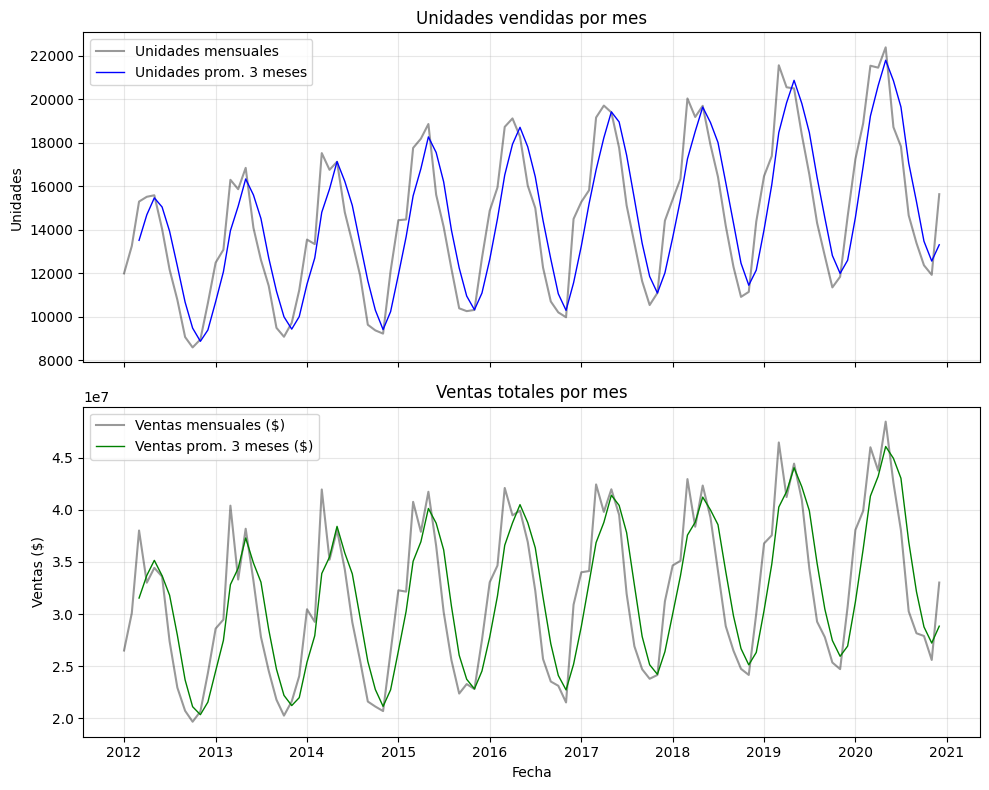

In [152]:

# Visualización mensual de unidades y ventas con promedio móvil de 3 meses.
ventas_mensuales_full = (
    ventas_diarias.set_index('Date')[['TotalUnidadesDia', 'TotalVentasDia']]
    .resample('MS')
    .sum()
    .assign(
        unidades_prom_3m=lambda df: df['TotalUnidadesDia'].rolling(window=3, min_periods=3).mean(),
        ventas_prom_3m=lambda df: df['TotalVentasDia'].rolling(window=3, min_periods=3).mean(),
    )
)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axes[0].plot(ventas_mensuales_full.index, ventas_mensuales_full['TotalUnidadesDia'], label='Unidades mensuales', alpha=0.4, color='black')
axes[0].plot(ventas_mensuales_full.index, ventas_mensuales_full['unidades_prom_3m'], label='Unidades prom. 3 meses', linewidth=1, color='blue')
axes[0].set_ylabel('Unidades')
axes[0].set_title('Unidades vendidas por mes')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(ventas_mensuales_full.index, ventas_mensuales_full['TotalVentasDia'], label='Ventas mensuales ($)', alpha=0.4, color='black')
axes[1].plot(ventas_mensuales_full.index, ventas_mensuales_full['ventas_prom_3m'], label='Ventas prom. 3 meses ($)', linewidth=1, color='green')
axes[1].set_ylabel('Ventas ($)')
axes[1].set_title('Ventas totales por mes')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_xlabel('Fecha')

plt.tight_layout()
plt.show()



## 2. Dinamica de Productos (5 Puntos)
2.2. Cree un unico grafico que muestre las series de tiempo de la cantidad vendida para la "Leche Entera 1L" y el "Helado Chocolate Suizo 1L". Compare visualmente los patrones de demanda de ambos e indique si sus tendencias y volatilidades son similares.

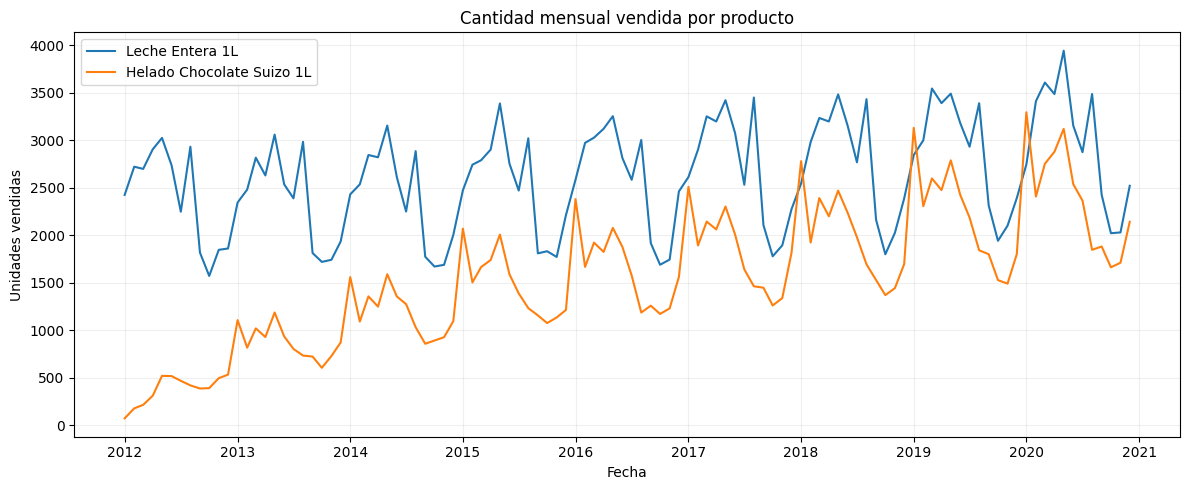

In [153]:
productos_dinamica = ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
serie_productos = (
    df[df['ProductName'].isin(productos_dinamica)]
    .groupby([pd.Grouper(key='Date', freq='MS'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
    .sort_values('Date')
)

helado = serie_productos[serie_productos['ProductName'] == 'Helado Chocolate Suizo 1L']
leche = serie_productos[serie_productos['ProductName'] == 'Leche Entera 1L']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(leche['Date'], leche['Quantity'], label='Leche Entera 1L')
ax.plot(helado['Date'], helado['Quantity'], label='Helado Chocolate Suizo 1L')

ax.set_title('Cantidad mensual vendida por producto')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades vendidas')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()


- La leche mantiene volumenes altos y relativamente estables, con oscilaciones moderadas a lo largo del periodo.
- El helado parte con demanda baja, pero acelera con fuerza desde 2015, mostrando picos mas marcados y mayor volatilidad.
- Ambas series comparten tendencia creciente, aunque la leche crece de forma gradual mientras el helado responde con variaciones mas abruptas, senal de volatilidades diferentes.

## 3. Analisis de Estacionalidad (5 Puntos)
3. Mediante graficos de cajas, analice la distribucion mensual de las ventas para la leche y el helado. Identifique los meses de mayor y menor demanda para cada producto y evalue si el helado se comporta de forma estacional mientras la leche permanece estable.

/var/folders/d9/2k27_l8j4kdf4z96lty3msz80000gn/T/ipykernel_94920/615117338.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['ProductName', 'MesNombre'])['Quantity']


Leche Entera 1L: mayor mediana en Mayo (3387 uds), menor en Octubre (1778 uds)
Helado Chocolate Suizo 1L: mayor mediana en Enero (2380 uds), menor en Octubre (1171 uds)


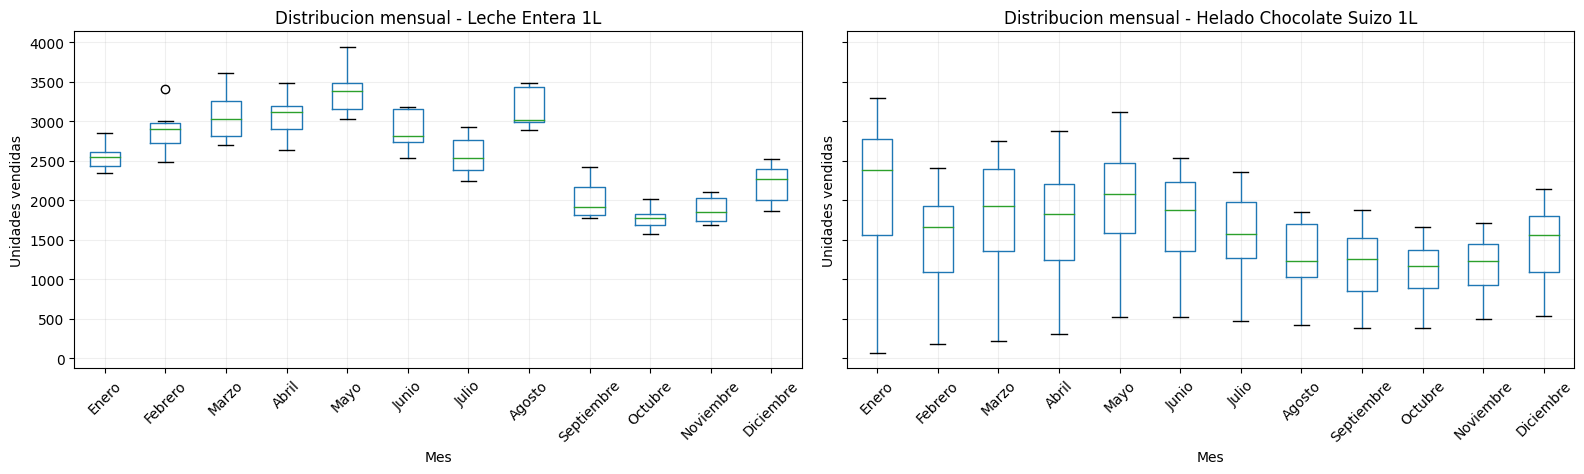

In [154]:
productos_estacionalidad = ["Leche Entera 1L", "Helado Chocolate Suizo 1L"]
ventas_mensuales_estacionalidad = (
    df[df['ProductName'].isin(productos_estacionalidad)]
    .groupby([pd.Grouper(key='Date', freq='MS'), 'ProductName'])['Quantity']
    .sum()
    .reset_index()
)

ventas_mensuales_estacionalidad['NroMes'] = ventas_mensuales_estacionalidad['Date'].dt.month
meses_largos = ["Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio", "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"]
ventas_mensuales_estacionalidad['MesNombre'] = ''
for i, nombre_mes in enumerate(meses_largos, start=1):
    filas_mes = ventas_mensuales_estacionalidad['NroMes'] == i
    if filas_mes.any():
        ventas_mensuales_estacionalidad.loc[filas_mes, 'MesNombre'] = nombre_mes

orden_meses = pd.CategoricalDtype(categories=meses_largos, ordered=True)
ventas_mensuales_estacionalidad['MesNombre'] = ventas_mensuales_estacionalidad['MesNombre'].astype(orden_meses)

fig, (ax_leche, ax_helado) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

leche = ventas_mensuales_estacionalidad[ventas_mensuales_estacionalidad['ProductName'] == 'Leche Entera 1L']
leche.boxplot(column='Quantity', by='MesNombre', ax=ax_leche, grid=False)
ax_leche.set_title('Distribucion mensual - Leche Entera 1L')
ax_leche.set_xlabel('Mes')
ax_leche.set_ylabel('Unidades vendidas')
ax_leche.tick_params(axis='x', rotation=45)
ax_leche.grid(alpha=0.2)

helado = ventas_mensuales_estacionalidad[ventas_mensuales_estacionalidad['ProductName'] == 'Helado Chocolate Suizo 1L']
helado.boxplot(column='Quantity', by='MesNombre', ax=ax_helado, grid=False)
ax_helado.set_title('Distribucion mensual - Helado Chocolate Suizo 1L')
ax_helado.set_xlabel('Mes')
ax_helado.set_ylabel('Unidades vendidas')
ax_helado.tick_params(axis='x', rotation=45)
ax_helado.grid(alpha=0.2)

plt.suptitle('')
plt.tight_layout()

resumen_medianas = (
    ventas_mensuales_estacionalidad
    .groupby(['ProductName', 'MesNombre'])['Quantity']
    .median()
    .unstack()
    .reindex(columns=meses_largos)
)
for producto in productos_estacionalidad:
    serie = resumen_medianas.loc[producto]
    mes_max = serie.idxmax()
    mes_min = serie.idxmin()
    print(f"{producto}: mayor mediana en {mes_max} ({serie.max():.0f} uds), menor en {mes_min} ({serie.min():.0f} uds)")


- La leche mantiene una dispersion acotada: los boxplots son angostos y las medianas se mantienen cercanas todo el ano, con leves maximos en Mayo-Junio y minimos en Octubre-Noviembre.
- El helado muestra fuerte estacionalidad: las medianas se disparan en los meses de verano (Enero-Febrero) y caen con fuerza hacia Octubre-Noviembre, ademas de tener cajas mas altas y asimetricas.
- En conjunto, los graficos respaldan que el helado es altamente estacional mientras la leche presenta demanda mas estable y predecible.

## 4. Preparacion de Datos (5 Puntos)
1. Agregacion Temporal (3 Puntos): Agregue los datos a una frecuencia regular (diaria, semanal o mensual) y justifique la eleccion equilibrando granularidad e interpretabilidad para retail.

In [155]:
# Para modelar, consolidamos la serie a frecuencia semanal.
# La semana suaviza ruido diario pero mantiene sensibilidad ante variaciones de retail.
frecuencia_modelo = 'W'
ventas_semanales = (
    df.set_index('Date')[['Quantity', 'TotalPrice']]
    .resample(frecuencia_modelo)
    .sum()
    .rename(columns={
        'Quantity': 'TotalUnidadesSemana',
        'TotalPrice': 'TotalVentasSemana'
    })
    .reset_index()
)

print(f'Frecuencia seleccionada: semanal ({frecuencia_modelo}). Registros resultantes: {len(ventas_semanales)}')
print(ventas_semanales.head())


Frecuencia seleccionada: semanal (W). Registros resultantes: 471
        Date  TotalUnidadesSemana  TotalVentasSemana
0 2012-01-01                  415             891000
1 2012-01-08                 2730            6016850
2 2012-01-15                 2722            6009400
3 2012-01-22                 2944            6272350
4 2012-01-29                 2599            6025850


- La agregacion semanal conserva la estacionalidad corta del retail (promociones, fines de semana) sin el ruido de transacciones individuales.
- Permite entrenar modelos con menos observaciones que la frecuencia diaria, reduciendo la varianza y el peso computacional.
- Aun asi, mantiene suficiente granularidad para detectar cambios de tendencia frente a agregaciones mensuales que podrian ocultar picos de demanda.

### 2. Division de Muestras (2 Puntos)
Segmentamos la serie semanal en conjuntos de entrenamiento (80 %) y prueba (20 %) para evaluar modelos sin fuga de informacion.

In [156]:
# Aseguramos que ventas_semanales este disponible (ejecuta la celda previa si es necesario).
total_registros = len(ventas_semanales)
punto_corte = int(total_registros * 0.8)
ventas_train = ventas_semanales.iloc[:punto_corte].copy()
ventas_test = ventas_semanales.iloc[punto_corte:].copy()


print(f'Registros totales: {total_registros}')
print(f'Tamano entrenamiento: {len(ventas_train)} (primer 80 %)')
print(f'Tamano prueba: {len(ventas_test)} (ultimo 20 %)')
print('Entrenamiento: fechas de', ventas_train['Date'].min().date(), 'a', ventas_train['Date'].max().date())
print('Prueba: fechas de', ventas_test['Date'].min().date(), 'a', ventas_test['Date'].max().date())
punto_corte


Registros totales: 471
Tamano entrenamiento: 376 (primer 80 %)
Tamano prueba: 95 (ultimo 20 %)
Entrenamiento: fechas de 2012-01-01 a 2019-03-10
Prueba: fechas de 2019-03-17 a 2021-01-03


376

- Mantener el 20 % final sin ver replica el escenario real: el modelo se entrena con el pasado y se valida con periodos futuros.
- Esta divisision evita fugas temporales y permite medir capacidad de generalizacion; un modelo que solo memoriza el pasado fallaria en el bloque de prueba.
- Con 80 % de entrenamiento preservamos suficiente informacion para ajuste de parametros sin sacrificar la ventana de prueba.

## 5. Pronostico
### 1. Justificacion del Modelo (5 Puntos)
Volvemos al esquema Holt-Winters aditivo para la **Leche Entera 1L**. El EDA mostro tendencia creciente y estacionalidad relativamente estable en amplitud: los picos invernales aumentan poco al subir el nivel general, lo que se ajusta mejor a un componente estacional aditivo (c_t se suma al nivel y tendencia).

Usamos frecuencia semanal (`periodo = 52`) y estimamos los parametros `α`, `β`, `γ` mediante busqueda en rejilla (0.1 a 0.9) minimizando el MAPE en `leche_train`. Las formulas aplicadas corresponden al Winters aditivo:
- Nivel `S_t = α(D_t - c_{t-n}) + (1-α)(S_{t-1} + G_{t-1})`
- Tendencia `G_t = β(S_t - S_{t-1}) + (1-β)G_{t-1}`
- Estacionalidad `c_t = γ(D_t - S_t) + (1-γ)c_{t-n}`
El pronostico es `F_{t+τ} = S_t + τG_t + c_{t+τ-n}`.


In [157]:
# Serie semanal del producto objetivo (leche) para entrenamiento y prueba
producto_objetivo = 'Leche Entera 1L'
serie_leche_semanal = (
    df[df['ProductName'] == producto_objetivo]
    .set_index('Date')['Quantity']
    .resample('W')
    .sum()
    .rename('UnidadesSemana')
)
serie_leche_semanal = serie_leche_semanal.asfreq('W', fill_value=0)

total_registros_leche = len(serie_leche_semanal)
punto_corte_leche = int(total_registros_leche * 0.8)
leche_train = serie_leche_semanal.iloc[:punto_corte_leche]
leche_test = serie_leche_semanal.iloc[punto_corte_leche:]

print(f'Registros semanales leche: {total_registros_leche}')
print(f'Tamano train: {len(leche_train)}, fechas {leche_train.index.min().date()} a {leche_train.index.max().date()}')
print(f'Tamano test: {len(leche_test)}, fechas {leche_test.index.min().date()} a {leche_test.index.max().date()}')


Registros semanales leche: 471
Tamano train: 376, fechas 2012-01-01 a 2019-03-10
Tamano test: 95, fechas 2019-03-17 a 2021-01-03


In [161]:
# MODELO: Holt-Winters aditivo implementado manualmente
from math import inf  # Valor infinito para inicializar comparaciones del MAPE

def inicializar_componentes(datos, periodo):  # Calcula nivel, tendencia y estacionalidad iniciales
    n_temporadas = len(datos) // periodo  # Numero de temporadas completas disponibles
    
    promedios_temporada = []  # Lista para guardar el promedio de cada temporada
    for j in range(n_temporadas):  # Recorre cada temporada completa
        segmento = datos[j * periodo:(j + 1) * periodo]  # Extrae los puntos de una temporada
        promedios_temporada.append(sum(segmento) / periodo)  # Calcula el promedio de esa temporada
    estacionales = [0.0] * periodo  # Inicializa los factores estacionales aditivos
    for i in range(periodo):  # Para cada posicion dentro del ciclo estacional
        estacionales[i] = sum(  # Promedio de las desviaciones respecto al promedio de cada temporada
            datos[j * periodo + i] - promedios_temporada[j]
            for j in range(n_temporadas)
        ) / n_temporadas
    nivel_inicial = promedios_temporada[0]  # Nivel base: promedio de la primera temporada
    suma_diferencias = 0.0  # Acumulara las diferencias entre temporadas consecutivas
    for i in range(periodo):  # Recorre cada posicion del ciclo
        suma_diferencias += (datos[periodo + i] - datos[i]) / periodo  # Cambio medio entre temporadas
    tendencia_inicial = suma_diferencias / periodo  # Promedia los cambios para obtener la pendiente inicial
    return nivel_inicial, tendencia_inicial, estacionales  # Devuelve los tres componentes inicializados

def holt_winters_aditivo(datos, periodo, alpha, beta, gamma):  # Ejecuta las ecuaciones de Winters aditivo
    valores = list(float(x) for x in datos)  # Convierte los datos a flotantes y a lista mutable
    nivel, tendencia, estacionales = inicializar_componentes(valores, periodo)  # Obtiene estado inicial
    ajustados = []  # Guardara los pronosticos dentro de muestra
    for t, dato in enumerate(valores):  # Recorre cada observacion
        idx_estacional = t % periodo  # Posicion dentro del ciclo estacional
        nivel_prev = nivel  # Guarda el nivel previo para actualizar la tendencia
        nivel = alpha * (dato - estacionales[idx_estacional]) + (1 - alpha) * (nivel + tendencia)  # Eq. de nivel
        tendencia = beta * (nivel - nivel_prev) + (1 - beta) * tendencia  # Eq. de tendencia
        estacionales[idx_estacional] = gamma * (dato - nivel) + (1 - gamma) * estacionales[idx_estacional]  # Eq. estacional
        ajustados.append(nivel + tendencia + estacionales[idx_estacional])  # Pronostico para el periodo t
    return ajustados, nivel, tendencia, estacionales  # Devuelve pronosticos y estado final

def pronosticar(nivel, tendencia, estacionales, periodo, pasos, posicion_final):  # Genera pronosticos futuros
    pronosticos = []  # Lista de resultados futuro
    for h in range(1, pasos + 1):  # Recorre cada horizonte futuro
        idx = (posicion_final + h) % periodo  # Posicion estacional para el horizonte h
        pronosticos.append(nivel + h * tendencia + estacionales[idx])  # Formula Ft+τ = St + τGt + ct+τ-n
    return pronosticos  # Retorna la serie pronosticada

def mape(real, pred, periodo):  # Calcula el error porcentual absoluto medio
    errores = []  # Lista de errores relativos
    for r, p in zip(real[periodo:], pred[periodo:]):  # Compara a partir de una temporada completa
        if r != 0:  # Evita division por cero
            errores.append(abs((r - p) / r))  # Error relativo absoluto de cada punto
    return (sum(errores) / len(errores)) * 100 if errores else inf  # Promedio porcentual o infinito

periodo_semanal = 52  # Ciclo estacional en semanas
valores_train = list(leche_train.values)  # Datos historicos del tramo de entrenamiento

mejor_mape = inf  # Inicializa el mejor error como infinito
mejores_parametros = (0.2, 0.1, 0.1)  # Semilla para los parametros alfa, beta, gamma
mejores_ajustados = []  # Guardara los pronosticos dentro de muestra del mejor modelo
mejor_estado = None  # Guardara nivel, tendencia y estacionales finales del mejor modelo
rangos = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  # Valores candidatos para los coeficientes
for alpha in rangos:  # Itera sobre posibles alfas (suavizado de nivel)
    for beta in rangos:  # Itera sobre posibles betas (suavizado de tendencia)
        for gamma in rangos:  # Itera sobre gammas (suavizado estacional)
            try:
                ajustados, nivel_final, tendencia_final, estacionales_final = holt_winters_aditivo(valores_train, periodo_semanal, alpha, beta, gamma)  # Ejecuta el algoritmo con la combinacion
            except ValueError:  # Si no hay suficientes temporadas para inicializar
                continue  # Omite esa combinacion
            mape_actual = mape(valores_train, ajustados, periodo_semanal)  # Calcula el error porcentual medio
            if mape_actual < mejor_mape:  # Si el error mejora al mejor actual
                mejor_mape = mape_actual  # Actualiza el mejor MAPE
                mejores_parametros = (alpha, beta, gamma)  # Guarda la combinacion optima
                mejores_ajustados = ajustados  # Guarda los pronosticos dentro de muestra
                mejor_estado = (nivel_final, tendencia_final, estacionales_final[:])  # Copia el estado final

alpha_opt, beta_opt, gamma_opt = mejores_parametros  # Parametros optimos encontrados
nivel_final, tendencia_final, estacionales_final = mejor_estado  # Estado final asociado al mejor modelo
posicion_final_train = len(valores_train) - 1  # Indice del ultimo periodo observado
pronostico_test_valores = pronosticar(nivel_final, tendencia_final, estacionales_final, periodo_semanal, len(leche_test), posicion_final_train)  # Pronosticos fuera de muestra
pronostico_train_leche = pd.Series(mejores_ajustados, index=leche_train.index, name='PronosticoSemana')  # Serie con ajustes dentro de muestra

pronostico_test_leche = pd.Series(pronostico_test_valores, index=leche_test.index, name='PronosticoSemana')  # Serie con pronosticos futuros

print('Parametros seleccionados (alpha, beta, gamma):', mejores_parametros)  # Reporta la combinacion optima
print(f'MAPE (train) con esos parametros: {mejor_mape:.2f}%')  # Muestra el error porcentual medio obtenido

print('Pronostico (train) ultimas semanas:')  # Encabezado para los ultimos ajustes
print(pronostico_train_leche.tail(3))  # Muestra las ultimas 3 semanas ajustadas
print('Pronostico (test) primeras semanas:')  # Encabezado de los pronosticos fuera de muestra
print(pronostico_test_leche.head(3))  # Muestra las primeras 3 semanas pronosticadas


Parametros seleccionados (alpha, beta, gamma): (0.8, 0.1, 0.8)
MAPE (train) con esos parametros: 0.44%
Pronostico (train) ultimas semanas:
Date
2019-02-24    795.577471
2019-03-03    764.921020
2019-03-10    693.253497
Freq: W-SUN, Name: PronosticoSemana, dtype: float64
Pronostico (test) primeras semanas:
Date
2019-03-17    691.111133
2019-03-24    680.594679
2019-03-31    674.160034
Freq: W-SUN, Name: PronosticoSemana, dtype: float64


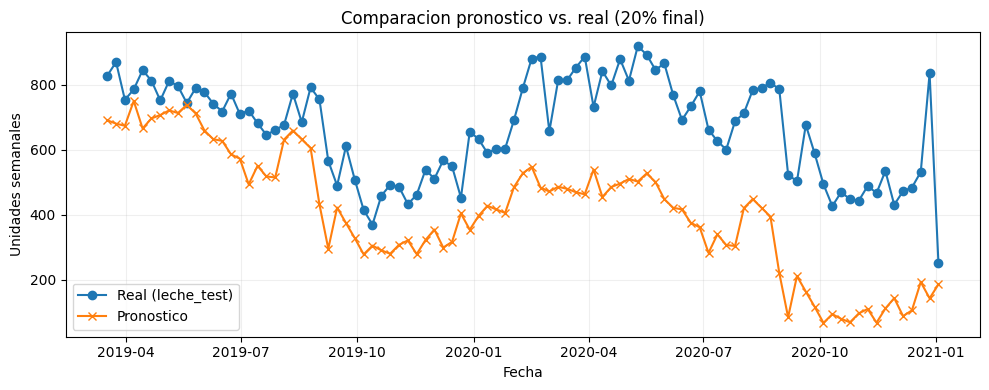

In [160]:
# Grafico comparativo para el bloque de prueba
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(leche_test.index, leche_test.values, label='Real (leche_test)', marker='o')
ax.plot(pronostico_test_leche.index, pronostico_test_leche.values, label='Pronostico', marker='x')
ax.set_title('Comparacion pronostico vs. real (20% final)')
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades semanales')
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
